In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.config import *
from src.prediction_functions import estimate_receptor_activity
from scipy.stats import ttest_ind
import matplotlib.cm as cm
from tqdm import tqdm



In [3]:
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from sklearn.decomposition import PCA
import statsmodels.stats.multitest as smm
from adjustText import adjust_text


# Prepare data

In [4]:
ligrec = pd.read_csv(LIG_REC_DF, index_col = 0)

In [5]:
lincs_model = pd.read_csv(f'data/coefficient_matrix/high_quality/all_pert_coef_liana.csv', index_col = 0)
lincs_model = lincs_model.T

In [6]:
accession = 'TIDE_Braun_et_al'

In [7]:
braun_meta= pd.read_excel(f'data/immunooncology/{accession}_clinical.xlsx', sheet_name='S1_Clinical_and_Immune_Data', header = 1)
braun_data = pd.read_excel(f'data/immunooncology/{accession}_clinical.xlsx', sheet_name='S4A_RNA_Expression', header = 1)
braun_data = braun_data.set_index('gene_name')

In [8]:
braun_meta_rnaseq = braun_meta[braun_meta['RNA_ID'].isin(list(braun_data.columns))]

In [9]:

braun_meta_rnaseq = braun_meta_rnaseq[['SUBJID', 'Arm', 'RNA_ID', 'Sex', 'Age', 'Received_Prior_Therapy', 
             'Number_of_Prior_Therapies', 'Tumor_Sample_Primary_or_Metastasis', 'ORR', 
             'Benefit', 'PFS', 'PFS_CNSR', 'OS', 'OS_CNSR', 'Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy', 
             'ImmunoPhenotype', 'SampleType']]

In [10]:
braun_data = braun_data.T.loc[braun_meta_rnaseq.RNA_ID]

In [11]:
braun_gex_merged = pd.merge(braun_meta_rnaseq, braun_data, left_on = 'RNA_ID', right_index = True)

# Calculate receptor activities

In [12]:
activities = estimate_receptor_activity(braun_data, lincs_model, number_of_permutations=1000, chunk_size=311)

Number of samples: 311
Number of chunks: 1
Number of permutations: 1000


100%|██████████| 1/1 [00:06<00:00,  6.33s/it]


In [13]:
braun_rec_merged = pd.merge(braun_meta_rnaseq, activities, left_on = 'RNA_ID', right_index = True)

In [14]:
# braun_gex_merged.to_csv(f'results/braun_gene_expression.csv')
# braun_rec_merged.to_csv(f'results/braun_receptor_activity.csv')

# Cox regression for PD-1, PD-L1

In [15]:
braun_gex_merged = pd.read_csv('results/braun_gene_expression.csv', index_col=0)
braun_rec_merged = pd.read_csv('results/braun_receptor_activity.csv', index_col=0)

In [16]:
braun_gex_data_merged = braun_gex_merged[braun_gex_merged['Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy'] <= 365]
braun_rec_merged = braun_rec_merged[braun_rec_merged['Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy'] <= 365]

In [17]:
def calculate_cox_for(gene:str, data:pd.DataFrame, duration = 'OS', event = 'OS_CNSR'):
    cph = CoxPHFitter()
    cph.fit(data[[duration, event, gene]], duration_col=duration, event_col=event, formula=f'{gene}')
    coef = cph.summary['coef'][gene]
    exp_coef = cph.summary['exp(coef)'][gene]
    pval = cph.summary['p'][gene]
    result = pd.Series([coef, exp_coef, pval], index = ['coef', 'exp(coef)', 'pval'], name = f'{gene}_{duration}')
    return result

In [18]:
res_1 = {}

In [19]:
res_1['PD1_gex_nivo'] = calculate_cox_for('PDCD1', braun_gex_data_merged[braun_gex_data_merged['Arm'] == 'NIVOLUMAB'], duration = 'OS', event = 'OS_CNSR')

In [20]:
res_1['CD274_gex_nivo'] = calculate_cox_for('CD274', braun_gex_data_merged[braun_gex_data_merged['Arm'] == 'NIVOLUMAB'], duration = 'OS', event = 'OS_CNSR')

In [21]:
res_1['PD1_rec_nivo'] = calculate_cox_for('PDCD1', braun_rec_merged[braun_rec_merged['Arm'] == 'NIVOLUMAB'], duration = 'OS', event = 'OS_CNSR')

In [22]:
res_1['PD1_gex_ever'] = calculate_cox_for('PDCD1', braun_gex_data_merged[braun_gex_data_merged['Arm'] == 'EVEROLIMUS'], duration = 'OS', event = 'OS_CNSR')

In [23]:
res_1['CD274_gex_ever'] = calculate_cox_for('CD274', braun_gex_data_merged[braun_gex_data_merged['Arm'] == 'EVEROLIMUS'], duration = 'OS', event = 'OS_CNSR')

In [24]:
res_1['PD1_rec_ever'] = calculate_cox_for('PDCD1', braun_rec_merged[braun_rec_merged['Arm'] == 'EVEROLIMUS'], duration = 'OS', event = 'OS_CNSR')

In [25]:
pd.DataFrame(res_1).T

,coef,exp(coef),pval
PD1_gex_nivo,-0.051318,0.949977,0.584923
CD274_gex_nivo,-0.069430,0.932926,0.629880
PD1_rec_nivo,-0.362175,0.696161,0.012374
PD1_gex_ever,-0.025614,0.974711,0.860376
CD274_gex_ever,0.142193,1.152799,0.477917
PD1_rec_ever,0.332046,1.393817,0.106053


In [26]:
# pd.DataFrame(res_1).T.to_csv('results/validation/anti_pd1/bulk/pd1_pdl1_cox_table.csv')

# Cox regression for all receptors

In [34]:
def calculate_cox_for_all_receptor(receptors:list, data:pd.DataFrame, duration = 'OS', event = 'OS_CNSR'):
    cph = CoxPHFitter()
    cox_results = pd.DataFrame(index = receptors, columns = ['coef', 'exp(coef)', 'p'])
    for receptor in receptors:

        cph.fit(data[[duration, event, receptor]], duration_col=duration, event_col=event, formula=f'{receptor}')
        cox_results.loc[receptor, 'coef'] = cph.summary['coef'][receptor]
        cox_results.loc[receptor, 'exp(coef)'] = cph.summary['exp(coef)'][receptor]
        cox_results.loc[receptor, 'p'] = cph.summary['p'][receptor]
    cox_results = cox_results.sort_values(by = 'coef')
    cox_results['rank'] = cox_results.coef.rank().astype(int)
    return cox_results

In [35]:
tmp = braun_rec_merged[(braun_rec_merged['Arm'] == 'NIVOLUMAB') & (braun_rec_merged['Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy'] <= 365)]
cox_results_os_nivo = calculate_cox_for_all_receptor(receptors = list(lincs_model.columns), data =  tmp)

In [36]:
padj = smm.multipletests(cox_results_os_nivo['p'], method = 'fdr_bh')[1]
cox_results_os_nivo['padj'] = padj

In [37]:
cox_results_os_nivo['log_p'] = -np.log10(cox_results_os_nivo['p'].astype(float))


In [38]:
# cox_results_os_nivo.to_csv('results/validation/anti_pd1/bulk/nivo_1yr_cox_receptors.csv')

In [39]:
confidence_scores = pd.read_csv(f'results/confidence/receptor_rocauc_mean_confidence_scores_229_mwup_withna.csv', index_col = 0)

In [40]:
cox_results_os_nivo_merged = cox_results_os_nivo.merge(confidence_scores[['Receptor', 'Confidence']], left_index = True, right_on= 'Receptor').set_index('Receptor').sort_values(by = 'coef')
cox_results_os_nivo_merged = cox_results_os_nivo_merged[['coef', 'exp(coef)', 'p', 'padj', 'Confidence']].rename(columns = {'coef':'Log_Hazard_Ratio', 'exp(coef)': 'Hazard_Ratio', 'p':'P-value', 'padj':'Adjusted p-value'})

In [41]:
# cox_results_os_nivo_merged.to_csv('results/validation/anti_pd1/bulk/nivo_1yr_cox_receptors_withconfidence.csv')

In [42]:
cox_results_os_nivo.sort_values(by = 'padj').head(20).sort_values(by = 'coef')

,coef,exp(coef),p,rank,padj,log_p
CXCR4,-0.677795,0.507735,0.00202,4,0.104126,2.694735
TLR4,-0.642365,0.526047,0.001413,5,0.104126,2.849763
HRH4,-0.574289,0.563105,0.002301,9,0.104126,2.638175
HRH2,-0.544875,0.579914,0.003704,12,0.109282,2.431286
AGTR1,-0.529251,0.589046,0.002191,13,0.104126,2.659294
FPR1,-0.425699,0.653313,0.003818,29,0.109282,2.418196
RAMP3,-0.423655,0.65465,0.002728,30,0.104126,2.564123
CCR6,-0.413817,0.661122,0.015072,33,0.117156,1.821823
NRP1,-0.390722,0.676568,0.01649,39,0.117156,1.782786
HRH1,-0.384572,0.680742,0.001578,41,0.104126,2.801907


In [43]:
cmap = cm.get_cmap('RdBu_r')
pal_blue = cmap(0.1)
pal_red = cmap(0.9) 

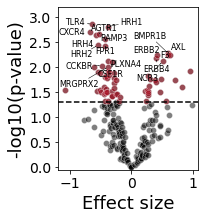

In [44]:
significance_threshold = -np.log10(0.05) 

plt.figure(figsize=(2.5, 3))
sns.scatterplot(data=cox_results_os_nivo, x='coef', y='log_p', color='k', alpha=0.5)

significant_indices = np.where(cox_results_os_nivo['log_p'] > significance_threshold)[0]
sns.scatterplot(data=cox_results_os_nivo.iloc[significant_indices], x='coef', y='log_p', color=pal_red, alpha=0.5)
plt.axhline(y=significance_threshold, color='black', linestyle='--')

texts = []
for x, y, name, p in zip(cox_results_os_nivo['coef'], cox_results_os_nivo['log_p'], cox_results_os_nivo.index, cox_results_os_nivo['p']):
#     if name == 'PDCD1':
#             texts.append(plt.text(x, y, f'{name}', ha='center', fontsize=8, color='red', fontweight='bold'))
    if p < 0.01:# or (abs(x) > 1.8 and y > significance_threshold): #2 or (abs(x) > 1.5 and y>
        texts.append(plt.text(x, y, f'{name}', ha='center', fontsize=8))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14) 
plt.xlabel('Effect size', fontsize = 18)
plt.ylabel('-log10(p-value)', fontsize = 18)
plt.ylim(-0.05, 3.2)
plt.show()

# Cox regression for all genes

In [45]:
def calculate_cox_for_all_gene(genes:list, data:pd.DataFrame, duration = 'OS', event = 'OS_CNSR'):
    cph = CoxPHFitter()
    cox_results = pd.DataFrame(index = genes, columns = ['coef', 'exp(coef)', 'p'])
    for gene in tqdm(genes):
        cph.fit(data[[duration, event, gene]], duration_col=duration, event_col=event, formula=f'{gene}')
        cox_results.loc[gene, 'coef'] = cph.summary['coef'][gene]
        cox_results.loc[gene, 'exp(coef)'] = cph.summary['exp(coef)'][gene]
        cox_results.loc[gene, 'p'] = cph.summary['p'][gene]
    cox_results = cox_results.sort_values(by = 'coef')
    cox_results['rank'] = cox_results.coef.rank().astype(int)
    return cox_results

In [46]:
tmp = braun_gex_data_merged[(braun_gex_data_merged['Arm'] == 'NIVOLUMAB') & (braun_gex_data_merged['Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy'] <= 365)]
tmp.columns = tmp.columns.str.replace('-', '_')
cox_results_gex_os_nivo = calculate_cox_for_all_gene(genes = list(lincs_model.columns), data =  tmp)

100%|██████████| 229/229 [00:11<00:00, 19.28it/s]


In [47]:
padj = smm.multipletests(cox_results_gex_os_nivo['p'], method = 'fdr_bh')[1]
cox_results_gex_os_nivo['padj'] = padj
cox_results_gex_os_nivo['log_p'] = -np.log10(cox_results_gex_os_nivo['p'].astype(float))


In [48]:
# cox_results_gex_os_nivo.to_csv('results/validation/anti_pd1/bulk/nivo_1yr_cox_gex.csv')

In [49]:
tmp = braun_rec_merged[(braun_rec_merged['Arm'] == 'EVEROLIMUS') & (braun_rec_merged['Days_from_TumorSample_Collection_and_Start_of_Trial_Therapy'] <= 365)]
cox_results_os_ever = calculate_cox_for_all_receptor(receptors = list(lincs_model.columns), data = tmp)

In [50]:
padj = smm.multipletests(cox_results_os_ever['p'], method = 'fdr_bh')[1]
cox_results_os_ever['padj'] = padj
cox_results_os_ever['-log10_p_value'] = -np.log10(cox_results_os_ever['p'].astype(float))

In [51]:
cox_results_os_ever_merged = cox_results_os_ever.merge(confidence_scores[['Receptor', 'Confidence']], left_index = True, right_on= 'Receptor').set_index('Receptor').sort_values(by = 'coef')
cox_results_os_ever_merged = cox_results_os_ever_merged[['coef', 'exp(coef)', 'p', 'padj', 'Confidence']].rename(columns = {'coef':'Log_Hazard_Ratio', 'exp(coef)': 'Hazard_Ratio', 'p':'P-value', 'padj':'Adjusted p-value'})

In [52]:
# cox_results_os_ever_merged.to_csv('results/validation/anti_pd1/bulk/ever_1yr_cox_receptor_withconfidence.csv')

In [53]:
# cox_results_os_ever.to_csv('results/validation/anti_pd1/bulk/ever_1yr_cox_receptor.csv')

In [54]:
receptors = activities.head()
ilrs = [s for s in receptors if "IL" in s]
ifnrs = [s for s in receptors if "IFN" in s]
tlrs = [s for s in receptors if "TLR" in s]
pd1r = [s for s in receptors if "PDCD1" in s]
tnfrs = [s for s in receptors if "TNF" in s]
agrs = [s for s in receptors if "AGTR" in s]

In [55]:
cox_results_os_nivo.loc[ifnrs + ['PDCD1']].sort_values(by = 'p')

,coef,exp(coef),p,rank,padj,log_p
PDCD1,-0.362175,0.696161,0.012374,49,0.117156,1.907491
IFNAR2,-0.379765,0.684022,0.047214,43,0.161255,1.325930
IFNAR1,-0.343833,0.709047,0.057177,54,0.167208,1.242781
IFNGR1,-0.27531,0.759337,0.249676,77,0.386323,0.602623
IFNGR2,-0.202463,0.816717,0.395987,97,0.521156,0.402319


# KM plots

In [56]:
def km_plot(gene:str, data:pd.DataFrame ,title:str, duration = 'OS', event = 'OS_CNSR', save = False, filepath = '', filename = ''):
    kmf = KaplanMeierFitter()
    kmdata = data.copy()
    palette = 'Blues'
    threshold = kmdata[gene].mean()
    
    # log-rank
    low_exp = kmdata[kmdata[gene] <= threshold]
    high_exp = kmdata[kmdata[gene] > threshold]
    results = logrank_test(low_exp[duration], high_exp[duration], event_observed_A=low_exp[event], event_observed_B=high_exp[event])

    cutoffs = [-np.inf, threshold, np.inf]
    labels = ['Low','High']
    kmdata['Activity Levels'] = pd.cut(kmdata[gene], bins=cutoffs, labels=labels)
    fig, ax = plt.subplots(figsize = (4.5,4))
    for category in labels:
        subset = kmdata[kmdata['Activity Levels'] == category]
        kmf.fit(subset[duration], subset[event], label=category)
        if category == 'High': 
            # color = palette[1]
            color = 'darkblue'
            label = f'> mean {gene} (high)'
        else: 
            # color = palette[0]
            color = 'darkred'
            label = f'< mean {gene} (low)'
        kmf.plot(ci_show = False,color = color, label = label, linewidth=2)

    # Add plot labels and legend
    plt.xlabel('Time (weeks)', fontsize = 12)
    plt.ylabel('Survival Probability', fontsize = 12)
    plt.title(f'Kaplan-Meier Plot by {title}', fontsize = 12)
    plt.legend(fontsize = 11)
    plt.ylim(-0.05, 1.05)

    plt.text(45, 0.6, s = f'log-rank:\nstat = {results.test_statistic:.2f}\np = {results.p_value:.4f}', fontsize = 12)

    if save:
        plt.savefig(f'{filepath}/{filename}.pdf', bbox_inches = 'tight', transparent = True)

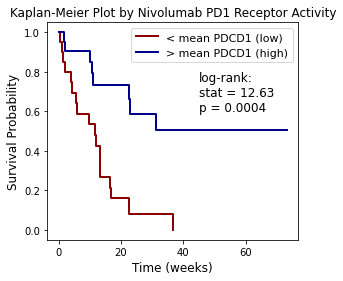

In [57]:

km_plot('PDCD1', braun_rec_merged[braun_rec_merged['Arm'] == 'NIVOLUMAB'], title = 'Nivolumab PD1 Receptor Activity', 
        save = False, filepath = 'figures/validation/anti_PD1/bulk/', filename = '')

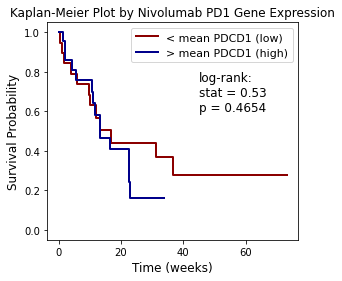

In [58]:
km_plot('PDCD1', braun_gex_data_merged[braun_gex_data_merged['Arm'] == 'NIVOLUMAB'], title = 'Nivolumab PD1 Gene Expression', 
        save = False, filepath = 'figures/validation/anti_PD1/bulk/', filename = '')

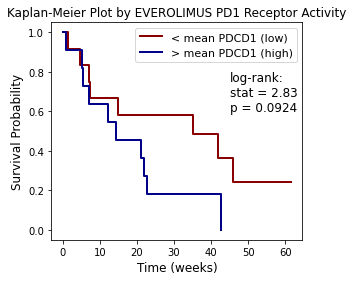

In [60]:
km_plot('PDCD1', braun_rec_merged[braun_rec_merged['Arm'] == 'EVEROLIMUS'], title = 'EVEROLIMUS PD1 Receptor Activity', 
        save = False, filepath = 'figures/validation/anti_PD1/bulk/', filename = '')